In [5]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
from src.metadata_processing.load_data import *
from src.metadata_processing.process_softchirp_features import find_outliers, choose_features
from src.audiodata_processing.extract_features_from_softchirps import compute_all_features
from src.audiodata_processing.process_traces import clear_trace
from src.metadata_processing.filters import filter_recs_metadata, filter_sounds_metadata_extended
from src.metadata_processing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from src.visualization.plot_softchirps import plot
from src.util import delete_indexes
import src.visualization.plot_softchirps
from notebooks.analysis.plotting_config import ORDER, COLOR, EPOCHS # change plotting_config file to change colors
from src.metadata_processing.process_sounds_metadata import generate_sounds_metadata
from src.audiodata_processing.process_waves import butter_highpass_filter
from src.audiodata_processing.extract_features_from_softchirps import *
from src.audiodata_processing.extract_features_from_wave import extract_mfcc

def extract_wav_features(wavs_list):
    wav_features = []
    for wav in wavs_list:
        pitch = compute_pitch(wav)
        amp = compute_amplitude(wav)
        ent = compute_wiener_ent(wav)
        zero_cr = compute_zero_crossing(wav)
        wav_features.append((pitch, amp, ent, zero_cr))
    return pd.DataFrame(wav_features, columns=['pitch', 'amplitude', 'entropy', 'zero crossing'])


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import matplotlib
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [3]:
# specify paths, where data is stored
path_to_info = PATH_TO_PROJECT + 'data/rat_info.csv'
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load, set filters here
colonies = ['lannister', 'martell', 'targaryen', 'nmr']
#colonies = 'all'
dates = 'all'
experiments = 'all'
stages = ['traced and checked', 'traced', 'traced and checked and checked', 'labeled and checked']


# specifies seconds to pixels ratio for spectrogram image
# uses librosa library which downsamples all audio files to 22050
freq_mult = 22050 / 2  / 128

# specify outliers,soft chirp traces outside of these ranges are excluded from analysis  
boundaries = {'slope' : (0.01, .2), 
              'frequency' : (2000, 8000), 
              'duration' : (0.05, 10),
              'height' : (300, 6000)}


columns_to_copy = ['colony', 'ratids', 'date', 'experiment']
max_sounds_per_class = {'softchirp': 5000}
max_sound_length = 12000
min_sound_length = 1337
min_sound_occurrences = 30
classes_to_drop = ['weirdo', 'badsplit', 'noise', 'sound']
sr = 22050

### Load data

In [4]:
# load info- and meta- data
info = load_info_file(path_to_info)
recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages, {})
sounds_metadata = generate_sounds_metadata(recs_metadata, classes_to_drop, max_sounds_per_class,
                                            min_sound_length, max_sound_length, columns_to_copy,
                                            sr=sr, min_sound_occurrences=min_sound_occurrences,
                                            print_counts=True)

# Load wavs
wavs = []
for s, e, rec_name in sounds_metadata[['s', 'e', 'rec']].values:
    wav = butter_highpass_filter(recs_dict[rec_name][int(sr * s) : int(sr * e)], 3000, sr)
    wavs.append(wav)
sounds_metadata_extended = extend_sounds_metadata(sounds_metadata, info)

Using 676 recordings


/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:37: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0).reset_index(drop=True)


softchirp      4990
pupcombo       1077
pupcheveron     189
pupsquawk       106
grunt            88
whistle          65
upsweep          56
downsweep        47
phee             41
hiccup           26
Name: cl, dtype: int64
No info for 3979
No info for 3981
No info for 3985
No info for 3984
No info for 1407
No info for 4272
No info for 4218
No info for 4214
No info for 4222
No info for 4226
No info for 4223
No info for 4407


/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:109: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat([sounds_metadata.reset_index(drop = True), columns_to_add], 1)


In [6]:
n_mel = 40
wav_features = extract_wav_features(wavs)
mfcc_features = pd.DataFrame(extract_mfcc(wavs, n_mel=n_mel), columns=
                             ['mfcc%d_mean' % i for i in range(1, n_mel + 1)] + 
                             ['mfcc%d_var' % i for i in range(1, n_mel + 1)] + 
                             ['mfcc%d_median' % i for i in range(1, n_mel + 1)])

### Single feature plots

In [ ]:
feature_to_study = 'amplitude'
# Choose from 'pitch', 'amplitude', 'entropy', 'zero crossing'

# specify data to use
print('Keys: ', list(sounds_metadata_extended.columns))
# specify filters
colonies = 'all'
weights = 'all'
dates = 'all'
sexes = 'all' # options: 'M', 'F', or 'all'
ages = 'all' # set range: (0, np.inf)
ranks = 'all' 
ratids =  'all'
excludeids = None # options: '1111', or None
bodylengths = 'all'# or set range
bodylengths2 = 'all' # or set range
sounds_per_rat = [0, 10000]
types = 'all'# options for types: 'single', 'pairs', or 'all'

mask =  filter_sounds_metadata_extended(sounds_metadata_extended, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
sounds_metadata_to_use = sounds_metadata_extended[mask]
print('Taking %.f %% sounds' % (100 *  mask.mean()))
chosen_feature_df = wav_features[feature_to_study]

In [75]:
colonies = sounds_metadata_to_use['colony'].unique()
per_colony_mask = {col: sounds_metadata_to_use['colony'] == col for col in colonies}
per_class_mask = {cl: sounds_metadata_to_use['cl'] == cl for cl in sound_types}
sound_types = sounds_metadata_to_use['cl'].unique()
print('Sound types:\n', sound_types, 'total sounds:', len(sound_types))
n_cols = 4
n_rows = int(np.ceil(len(sound_types) / n_cols))
n_cols, n_rows

Sound types:
 ['softchirp' 'grunt' 'whistle' 'upsweep' 'downsweep' 'pupcombo'
 'pupsquawk' 'phee' 'hiccup' 'pupcheveron'] total sounds: 10


(4, 3)

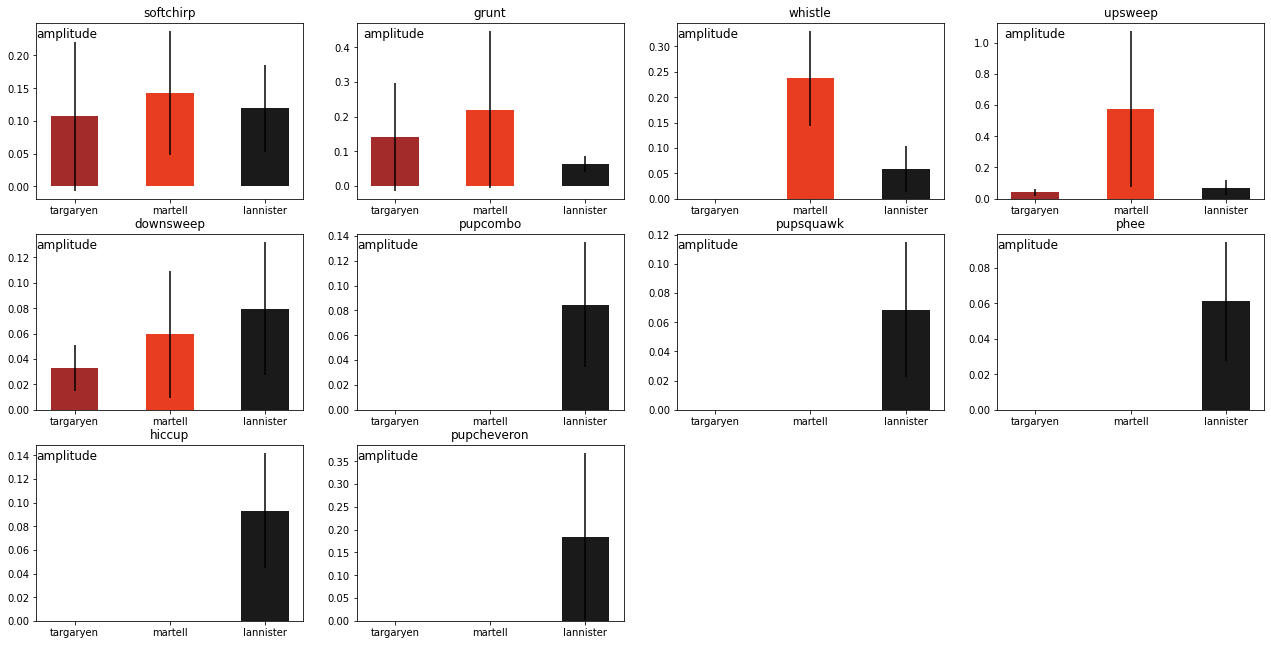

In [76]:
x_num = np.arange(1, len(colonies) + 1)
ylims = (0, 1) # Set to None, then each plot will have individual ylim
ylims = None
plt.figure(figsize=(22, 11))
for i in range(n_rows):
    for j in range(n_cols):
        count = i * n_cols + j
        if count >= len(sound_types):
            break
        cl = sound_types[count]
        mask = per_class_mask[cl]
        plt.subplot(n_rows, n_cols, count + 1)
        means = [np.nanmean((chosen_feature_df[mask * per_colony_mask[col]]).values) for col in colonies]
        variances = [np.nanstd((chosen_feature_df[mask * per_colony_mask[col]]).values) for col in colonies]
        
        colors = [COLOR['colony'][col] for col in colonies]
        plt.bar(x_num, means, yerr=variances, color=colors, width=0.5)
        plt.xticks(x_num, colonies)
        plt.title(cl)
        plt.xlim(.6, len(colonies) + .4)
        plt.ylabel(feature_to_study, rotation=0, fontsize=12,labelpad=-60,y=0.9)
        if ylims is not None:
            plt.ylim(ylims)
#plt.savefig('name.svg')

### Variance of variances

In [79]:
def choose_features(feature_names, wav_features, mfcc_features):
    if feature_names == 'all':
        return pd.concat([wav_features, mfcc_features], axis=1)
    features_to_use = []
    for f in feature_names:
        if f == 'mfcc':
            f_list = mfcc_features[mask]
        else:
            f_list = wav_features[f]
        features_to_use.append(f_list)
    return pd.concat(features_to_use, axis=1)

In [ ]:
# Transform this the plot above into single feature regime, add feature as a title
# Make variance of variances plot
# Add option to save data as a csv file


In [80]:
features_to_study = ['pitch', 'mfcc']
features_to_study = 'all'
# A list with elements from 'pitch', 'amplitude', 'entropy', 'zero crossing', 'mfcc' or a string 'all'

# specify data to use
print('Keys: ', list(sounds_metadata_extended.columns))
# specify filters
colonies = 'all'
weights = 'all'
dates = 'all'
sexes = 'all' # options: 'M', 'F', or 'all'
ages = 'all' # set range: (0, np.inf)
ranks = 'all' 
ratids =  'all'
excludeids = None # options: '1111', or None
bodylengths = 'all'# or set range
bodylengths2 = 'all' # or set range
sounds_per_rat = [0, 10000]
types = 'all'# options for types: 'single', 'pairs', or 'all'

mask =  filter_sounds_metadata_extended(sounds_metadata_extended, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
sounds_metadata_to_use = sounds_metadata_extended[mask]
print('Taking %.f %% sounds' % (100 *  mask.mean()))
features_to_use = choose_features(features_to_study, wav_features, mfcc_features)[mask].reset_index(drop=True)
features_to_use_normalized = pd.DataFrame(features_to_use.values, columns=features_to_use.columns)
for col in features_to_use_normalized.columns:
    features_to_use_normalized[col] = ((features_to_use_normalized[col] - features_to_use_normalized[col].min())
                                       / (features_to_use_normalized[col].max()
                                          - features_to_use_normalized[col].min()))


Keys:  ['s', 'e', 'cl', 'rec', 'colony', 'ratids', 'date', 'experiment', 'weight', 'sex', 'rank', 'dob', 'age', 'bodylength', 'bodylength2']
Taking 100 % sounds


In [92]:
colonies = sounds_metadata_to_use['colony'].unique()
sound_types = sounds_metadata_to_use['cl'].unique()
colony_class_mask = {(col, cl): per_colony_mask[col] & per_class_mask[cl] 
                     for col in colonies for cl in sound_types}
n_cols = 4
n_rows = int(np.ceil(len(sound_types) / n_cols))
n_cols, n_rows

(4, 3)

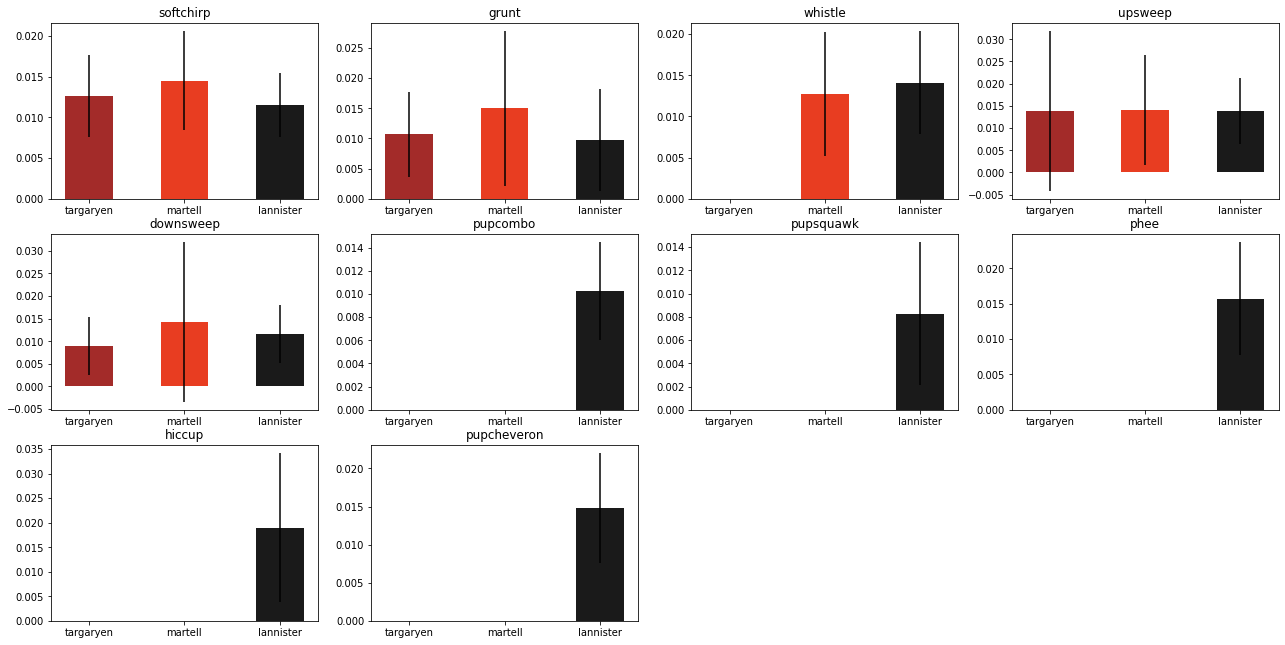

In [125]:
variances_csv = []
x_num = np.arange(1, len(colonies) + 1)
ylims = (0, 1) # Set to None, then each plot will have individual ylim
ylims = None
plt.figure(figsize=(22, 11))
for i in range(n_rows):
    for j in range(n_cols):
        count = i * n_cols + j
        if count >= len(sound_types):
            break
        cl = sound_types[count]
        means = []
        variances = []
        for col in colonies:
            mask = colony_class_mask[(col, cl)]
            per_feature_var = features_to_use_normalized[mask].var(axis=0)
            means.append(np.mean(per_feature_var))
            variances.append(np.std(per_feature_var))
            per_feature_var['colony'] = col
            per_feature_var['cl'] = cl
            variances_csv.append(per_feature_var)
        colors = [COLOR['colony'][col] for col in colonies]
        plt.subplot(n_rows, n_cols, count + 1)
        plt.bar(x_num, means, yerr=variances, color=colors, width=0.5)
        plt.xticks(x_num, colonies)
        plt.title(cl)
        plt.xlim(.6, len(colonies) + .4)
        #plt.ylabel(feature_to_study, rotation=0, fontsize=12,labelpad=-60,y=0.9)
variances_csv = pd.concat(variances_csv, axis=1).T
variances_csv = variances_csv[list(variances_csv.columns[-2:]) + list(variances_csv.columns[:-2])]
#plt.savefig('name.svg')

In [127]:
# The resulting csv. Each number is variance of a certain feature, for certain colony and sound type
variances_csv.head(10)
variances_csv.to_csv('variances.csv')